# Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.


We generate a random secret floating number. Then we use hamming weight model to guess the number.

We develop a method of devide-and-conquer to quickly arrive to a close number with a defined precision.

## Guessing...

In [62]:
import struct
import numpy as np
import pandas as pd
import random
from pprint import pprint
import hashlib
import binascii
from guess_range import *

In [63]:
def generate_known_inputs(exps=(-1, 3), nsize=3000):
    low, high = exps[0], (exps[1] + 1)
    subsize = int(nsize / (high - low))
    return pd.DataFrame(
        data=[np.random.uniform(-10.0 ** i, 10.0 ** i, subsize) for i in range(low, high)],
        index=range(low, high))

def secret_signature(secret_numbers):
    m = hashlib.md5()
    m.update(secret_numbers)
    a = m.digest()
    s = 2
    n = [0] * s
    for idx in range(len(a)):
        i = idx % s
        n[i] = (n[i] + a[idx]) % 256
    return binascii.hexlify(bytes(n))        

In [3]:
def guess_number_range_stat(secret_number, guess_range, prescision, known_input_size=3000):
    known_input_set = generate_known_inputs(exps=(-1, 3), nsize=known_input_size)
    results = guess_number_range_multiple_inputs(secret_number, guess_range, prescision, known_input_set)
    # pprint(results)
    #
    # discard low correlation results
    corr_values = results[CORRELATION]
    results = results[corr_values > (corr_values.max() * 0.95)].sort_values(CORRELATION, ascending=False)
    guess_values = ((results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0).round(decimals=int(-np.log10(prescision)))
    return results[~guess_values.duplicated(keep='first')]

In [4]:
SECRET_VALUE = 'secret value'

guess_range = (-5e0, 5.0e0)
prescision = 1e-7
#
# initalize parameter and generate a random number (secret number)
known_input_size = 10000

## Test single point

In [5]:
secret_number = random.uniform(guess_range[0] / 10, guess_range[1] / 10) 

In [6]:
%%time
single_results = guess_number_range_stat(secret_number, guess_range, prescision, known_input_size)
print(secret_number)
single_results

-0.45024397022219753
CPU times: user 1min 2s, sys: 1.87 s, total: 1min 4s
Wall time: 1min 4s


,low value,high value,correlation
-1,-0.450244,-0.450244,0.999826


In [7]:
guess_values = (single_results[LOW_VALUE] + single_results[HIGH_VALUE]) / 2.0
error_rates = ((guess_values - secret_number) / secret_number).abs() * 100.0
pprint(error_rates)
guessed_number = guess_values[error_rates.idxmin()]    
pprint('the secret number = %f' % secret_number)
pprint('the guessed number = %f' % guessed_number)
pprint('best correlation = %f' % single_results[CORRELATION][error_rates.idxmin()])
pprint('error rate = %0.6f%s' % (error_rates.min(), '%'))

-1    0.000004
dtype: float64
'the secret number = -0.450244'
'the guessed number = -0.450244'
'best correlation = 0.999826'
'error rate = 0.000004%'


## Test multiple points

In [8]:
multiple_results = pd.DataFrame()

In [9]:
n_secret_numbers = 100
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (100,)


In [10]:
%%time
loops = 0
for idx in secret_numbers:
    # if the number is already treated, the ignore it
    if (SECRET_VALUE in multiple_results.columns) and (idx in multiple_results[SECRET_VALUE].values):
        continue    
    results = guess_number_range_stat(idx, guess_range, prescision, known_input_size)
    results[SECRET_VALUE] = idx
    pprint('=' * 20)
    pprint(results)
    guess_values = (results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0
    multiple_results = pd.concat([multiple_results, results], axis=0, ignore_index=True)
    loops = loops + 1

'===================='
   low value  high value  correlation  secret value
0  -3.284259   -3.284259          1.0     -3.284259
'===================='
   low value  high value  correlation  secret value
2   2.387437    2.387437          1.0      2.387437
'===================='
   low value  high value  correlation  secret value
3  -0.687093   -0.687092          1.0     -0.687092
'===================='
   low value  high value  correlation  secret value
1  -0.472725   -0.472725     0.999906     -0.472725
0  -1.890900   -1.890900     0.985141     -0.472725
'===================='
   low value  high value  correlation  secret value
1  -0.236893   -0.236893     0.883153     -0.236893
'===================='
    low value  high value  correlation  secret value
 3  -0.777049   -0.777049     0.999966     -0.777049
-1  -3.108195   -3.108195     0.972162     -0.777049
'===================='
    low value  high value  correlation  secret value
-1   3.837977    3.837977          1.0      3.837977
'=

'===================='
    low value  high value  correlation  secret value
 1  -1.096423   -1.096423     1.000000     -1.096423
-1  -4.385691   -4.385691     0.978161     -1.096423
'===================='
   low value  high value  correlation  secret value
2  -0.378253   -0.378253     0.999965     -0.378253
0  -1.513014   -1.513014     0.980562     -0.378253
'===================='
    low value  high value  correlation  secret value
 2  -0.076697   -0.076696     0.998311     -0.076697
-1  -1.227144   -1.227144     0.992716     -0.076697
'===================='
   low value  high value  correlation  secret value
1   0.352845    0.352845     0.998764      0.352845
0   1.411380    1.411380     0.979347      0.352845
'===================='
    low value  high value  correlation  secret value
-1  -4.248722   -4.248722          1.0     -4.248722
'===================='
   low value  high value  correlation  secret value
0  -4.816189   -4.816189          1.0     -4.816189
'===================='

### Save data

In [74]:
from datetime import datetime
multiple_results_fname = 'multiple_results-%s_%s.csv' % (datetime.now().strftime("%Y%m%d"), secret_signature(secret_numbers).decode('utf8'))
multiple_results.to_csv(multiple_results_fname)
pprint('multiple_results_fname = %s' % multiple_results_fname)

'multiple_results_fname = multiple_results-20200523_9dcc.csv'


### Load data

In [28]:
# multiple_results_fname = 'multiple_results-20200523_011136.csv'
multiple_results = pd.read_csv(multiple_results_fname, index_col=0)
multiple_results

,low value,high value,correlation,secret value
0,-3.284259,-3.284259,1.000000,-3.284259
1,2.387437,2.387437,1.000000,2.387437
2,-0.687093,-0.687092,1.000000,-0.687092
3,-0.472725,-0.472725,0.999906,-0.472725
4,-1.890900,-1.890900,0.985141,-0.472725
...,...,...,...,...
149,-4.854488,-4.854488,1.000000,-4.854488
150,-2.640574,-2.640574,1.000000,-2.640574
151,0.148523,0.148523,0.999661,0.148523
152,2.376374,2.376374,0.981078,0.148523


### Hit targets and missed targets

In [29]:
#
# compute the number of secret values which are present in guessed ranges
n_identified_ranges = multiple_results.groupby(SECRET_VALUE).apply(lambda x: ((x[LOW_VALUE]<=x[SECRET_VALUE]) & (x[SECRET_VALUE]<=x[HIGH_VALUE])).any())
counts = n_identified_ranges.value_counts()
if True in counts.index:
    pprint('The number of identified values: %d/%d' % (counts[True], counts.sum()))
if False in counts.index:
    pprint('The number of missed values: %d/%d' % (counts[False], counts.sum()))

'The number of identified values: 92/100'
'The number of missed values: 8/100'


### Graphs of the first choices

In [14]:
first_choice_results = multiple_results.loc[multiple_results.groupby(SECRET_VALUE)[CORRELATION].idxmax()]

# the number of correct values
n_correct_values = first_choice_results.apply(lambda x: (x[LOW_VALUE]<=x[SECRET_VALUE]) & (x[SECRET_VALUE]<=x[HIGH_VALUE]), axis=1)
pprint(n_correct_values.value_counts())

guess_values = (first_choice_results[LOW_VALUE] + first_choice_results[HIGH_VALUE]) / 2.0
guess_values.index = first_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)

True     89
False    11
dtype: int64


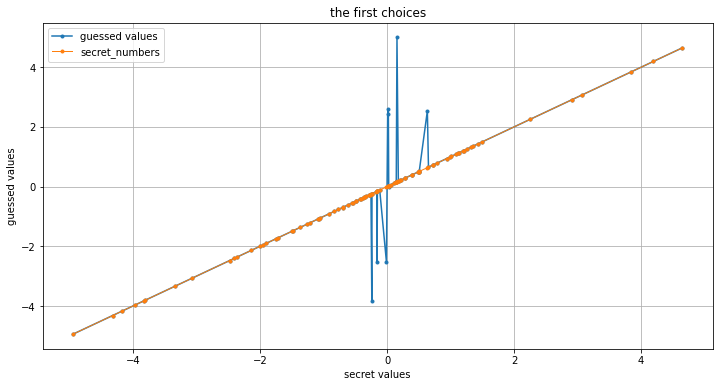

In [15]:
ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the first choices')
ax.grid(True)

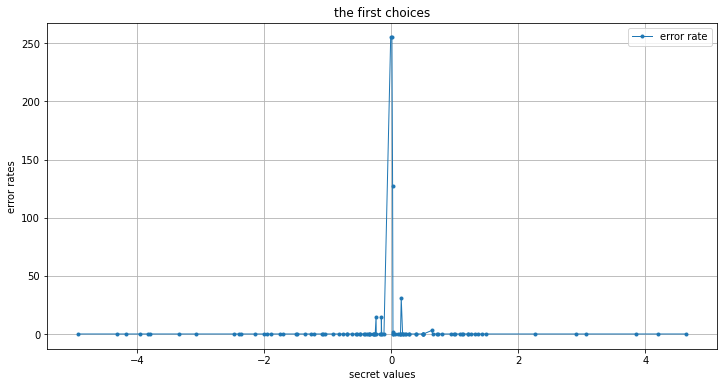

In [16]:
error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the first choices')
ax.grid(True)

### Graphs of the second choice

In [17]:
pprint('The total number of the second choices is: %d' % (multiple_results.groupby(SECRET_VALUE).size().prod()-1))

'The total number of the second choices is: 17099604835172351'


In [18]:
guess_values = ((multiple_results[LOW_VALUE] + multiple_results[HIGH_VALUE]) / 2.0)
error_rate = ((guess_values - multiple_results[SECRET_VALUE])/multiple_results[SECRET_VALUE]).abs()
second_choice_results = multiple_results.loc[error_rate.groupby(multiple_results[SECRET_VALUE]).idxmin()]
guess_values = ((second_choice_results[LOW_VALUE] + second_choice_results[HIGH_VALUE]) / 2.0)
guess_values.index = second_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)

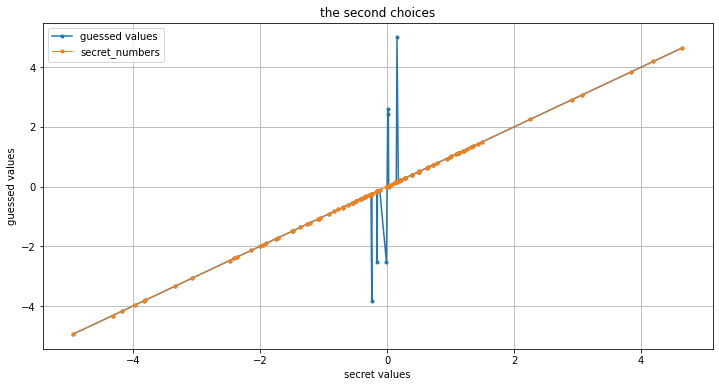

In [19]:
ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the second choices')
ax.grid(True)

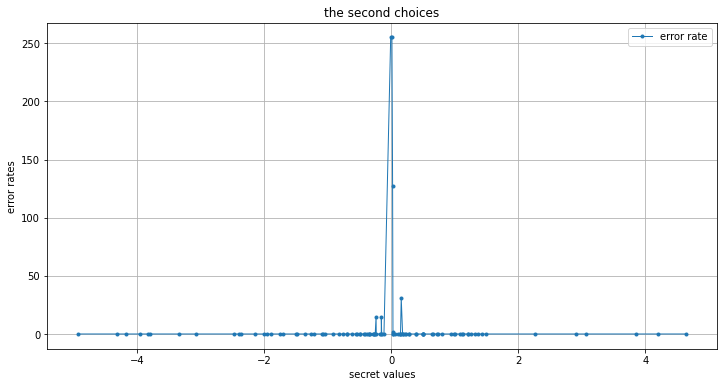

In [20]:
error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the second choices')
ax.grid(True)

# Batina method

In [53]:
def batina_guess_number(secret_number, guess_range, prescision, known_inputs):
    low, high = guess_range
    guess_val = np.arange(low, high, prescision)
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    hw['actual'] = np.vectorize(hamming_weight)(known_inputs * secret_number)
    return hw.corr(method='pearson')['actual'].drop('actual').idxmax()

In [ ]:
batinta_results = pd.Series(name='guessed_numbers', dtype=np.float32)

In [52]:
# we have to define a low precision, otherwise, it takes too long time to run
prescision = 1e-3
known_inputs = np.random.uniform(-1e1, 1e1, 1000)

In [77]:
%%time
for idx in secret_numbers:
    if idx in batinta_results.index:
        continue    
    batinta_results[idx] = batina_guess_number(idx, guess_range, prescision, known_inputs)
    print('secret_value = %f, guessed_value = %f' % (idx, batinta_results[idx]))
batinta_results.sort_index(inplace=True)    

secret_value = -0.236893, guessed_value = -0.237000
secret_value = 3.837977, guessed_value = 3.838000
secret_value = -3.679204, guessed_value = -3.679000
secret_value = 4.449552, guessed_value = 4.449000
secret_value = 0.332456, guessed_value = 0.332000
secret_value = 3.216816, guessed_value = 3.217000
secret_value = 0.200418, guessed_value = 3.206000
secret_value = 0.214317, guessed_value = 0.214000
secret_value = 2.272627, guessed_value = 2.273000
secret_value = 0.162747, guessed_value = 2.604000
secret_value = 0.278909, guessed_value = 0.279000
secret_value = 0.241718, guessed_value = 0.242000
secret_value = -1.455040, guessed_value = -1.455000
secret_value = 4.594359, guessed_value = 4.594000
secret_value = 1.958890, guessed_value = 1.959000
secret_value = -0.089913, guessed_value = -2.877000
secret_value = -0.393440, guessed_value = -0.394000
secret_value = -0.422019, guessed_value = -0.422000
secret_value = 0.352845, guessed_value = 0.353000
secret_value = -4.816189, guessed_valu

### Save data

In [78]:
from datetime import datetime
batinta_results_fname = 'batinta_results-%s_%s.csv' % (datetime.now().strftime("%Y%m%d"), secret_signature(secret_numbers).decode('utf8'))
batinta_results.to_csv(batinta_results_fname)
pprint('batinta_results_fname = %s' % batinta_results_fname)

'batinta_results_fname = batinta_results-20200523_9dcc.csv'


### Load data

In [79]:
# batinta_results_fname = 'batinta_results-%s.csv' % '20200522_071337'
batinta_results = pd.read_csv(batinta_results_fname, index_col=0, squeeze=True)
batinta_results.sort_index(inplace=True)    
batinta_results

-4.854488   -4.854
-4.816189   -4.816
-4.816189   -4.816
-4.593031   -4.593
-4.248722   -4.249
             ...  
 4.449552    4.450
 4.488719    4.489
 4.594359    4.594
 4.594359    4.594
 4.613159    4.613
Name: guessed_numbers, Length: 131, dtype: float64

### Graphs

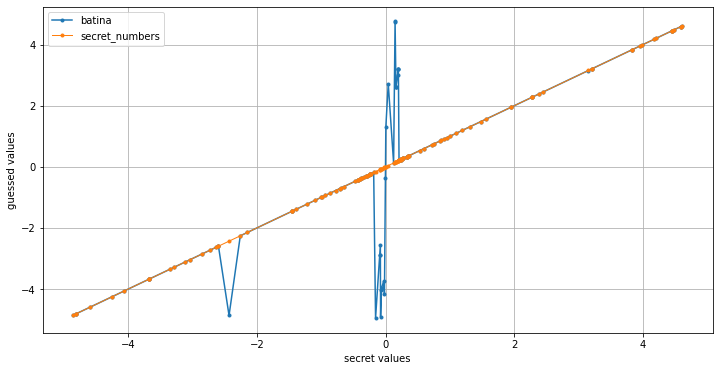

In [80]:
ax = batinta_results.plot(figsize = (12, 6), marker='.', label='batina')
#results.plot(ax=ax, marker='.', label='bxlab')
ax.plot(batinta_results.index, batinta_results.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.grid(True)

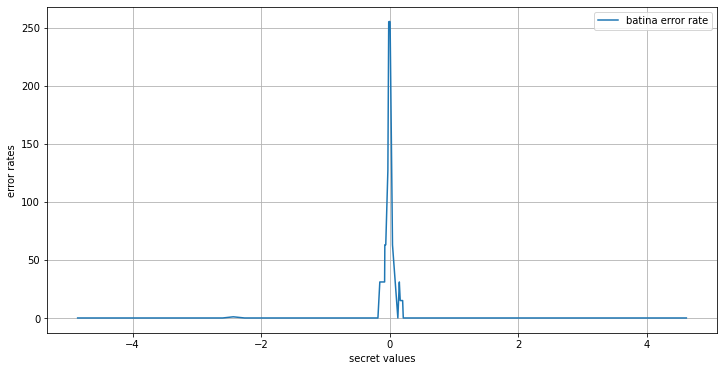

In [81]:
batina_error_rate = ((batinta_results - batinta_results.index)/batinta_results.index).abs()
ax = batina_error_rate.plot(figsize = (12, 6), label='batina error rate')
#ax = error_rate.plot(ax=ax, label='error rate')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.grid(True)

In [82]:
batina_error_rate[batina_error_rate > 0.10]

-2.433509      0.999992
-0.154657     30.999790
-0.089913     30.997552
-0.089913     30.997552
-0.080027     31.001784
-0.076697     62.992490
-0.062795     63.001525
-0.062136     63.004641
-0.029280    127.006998
-0.016269    255.007483
-0.001374    255.256193
 0.005106    254.970107
 0.042528     62.982030
 0.148523     31.001691
 0.148798     30.996367
 0.162747     15.000295
 0.162747     15.000295
 0.162747     15.000295
 0.188606     15.001624
 0.200418     14.996595
 0.200418     15.001585
 0.200418     14.996595
dtype: float64

In [83]:
(batina_error_rate < 0.10).value_counts()

True     109
False     22
dtype: int64